<center><h1>Clustering Casablanca's Restaurants</h1></center>

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    python_abi-3.6             |          1_cp36m           4 KB  conda-forge
    certifi-2020.6.20          |   py36h9f0ad1d_0         151 KB  conda-forge
    geopy-2.0.0                |     pyh9f0ad1d_0          63 KB  conda-forge
    ca-certificates-2020.6.20  |       hecda079_0         145 KB  conda-forge
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    openssl-1.1.1g             |       h516909a_0         2.1 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.5 MB

The following NEW packages will be INSTALLED:

    geographiclib:   1.50-py_0          conda-forge
    geopy:           

## 1. Data preparing and exploring (Neighborhoods Data & Venues)

In [112]:
df = pd.read_html('https://sites.google.com/site/collectivitesaumaroc/regions/grand-casablanca/provinces-et-communes-du-grand-casablance')[3]
'''df.drop(df[df.Neighborhood == "Not assigned"].index, inplace=True)
coords=pd.read_csv('https://cocl.us/Geospatial_data')
neig_data= pd.merge(df,coords, on = 'Postal Code',how='inner')
print(neig_data.shape)'''
df.drop('NATURE', axis=1, inplace=True)
df.drop('ADRESSE', axis=1, inplace=True)
df.drop('PREFECTURE', axis=1, inplace=True)
df.rename(columns={"COMMUNE": "Borough"}, inplace=True)
print(df.shape)
df.set_index('Borough')
df.drop(df[df.Borough == "CASABLANCA (CP)"].index, inplace=True)
df.drop(df[df.Borough == "CASABLANCA (RG)"].index, inplace=True)
df.drop(df[df.Borough == "Ouled Azouz"].index, inplace=True)

df['Borough'] = df['Borough'].str.rstrip('(AR)')
df['Borough'] = df['Borough'].str.rstrip('(M)')
df['Borough'] = df['Borough'].str.rstrip('(CP)')
df.drop(df[df.Borough == "SIDI HAJJAJ OUED HASS"].index, inplace=True)
df.drop(df[df.Borough == "ECH-CHALLALATE"].index, inplace=True)
df['Borough'][2] ='CASABLANCA'
df['Borough'][35] ='BOUSKOURA'
df['Borough'][36] ='DAR BOUAZZA'
df['Borough'][9] ='MAARIF CASABLANCA'
df['Borough'][6] ='EL-FIDA Casablanca'

df.drop_duplicates(subset=None, keep='first', inplace=True)

df['Borough'] = df['Borough'].str.capitalize() 
df


(39, 1)


,Borough
2,Casablanca
3,Aîn-chock
4,Aîn-sebaâ
5,Anfa
6,El-fida casablanca
7,Assoukhour assawda
8,Ben m'sick
9,Maarif casablanca
10,Hay-hassani
11,Hay mohammadi


### Create a function to get the coordonates of a giving address and adding two columns to our datafram that contain the longitude an the latitude of each Borough

In [113]:
def getLonLat(address):

    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    lonlat=[latitude,longitude]
    return(lonlat)
    
df["Latitude"] = np.nan
df["Longitude"] = np.nan


for ind in df.index: 
    x=getLonLat(df['Borough'][ind])[1]
    y=getLonLat(df['Borough'][ind])[0]
    print("{} | lon: {} | lat: {}".format(df['Borough'][ind],x,y)) 
    df['Latitude'][ind] = y
    df['Longitude'][ind]= x
  

Casablanca | lon: -7.6187768 | lat: 33.5950627


/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Aîn-chock  | lon: -7.6156977 | lat: 33.5362148
Aîn-sebaâ  | lon: -7.524144079373121 | lat: 33.6085906
Anfa  | lon: -7.6721766 | lat: 33.5926317
El-fida casablanca | lon: -7.6072879 | lat: 33.5665224
Assoukhour assawda  | lon: -7.588056195247534 | lat: 33.58651905
Ben m'sick  | lon: -7.5813658 | lat: 33.5542611
Maarif casablanca | lon: -7.63666 | lat: 33.5761303
Hay-hassani  | lon: -7.6784886 | lat: 33.5670464
Hay mohammadi  | lon: -7.5569559 | lat: 33.5841444
Mers-sultan  | lon: -7.5999288 | lat: 33.5757681
Moulay rachid  | lon: -7.5452441 | lat: 33.5675448
Sbata  | lon: -5.5668732 | lat: 33.8807662
Sidi belyout  | lon: -7.6263135 | lat: 33.5949432
Sidi bernoussi  | lon: -7.5003234 | lat: 33.6190686
Sidi moumen  | lon: -7.5072051 | lat: 33.5843834
Sidi othmane  | lon: -7.5603844 | lat: 33.5570072
Mechouar de casablanca  | lon: -7.6056854759701995 | lat: 33.5795289
Mediouna  | lon: -7.51944 | lat: 33.456251
Tit mellil  | lon: -7.483552 | lat: 33.551412
Al majjatia oulad taleb | lon: -7.

### Create a map of Toronto with neighborhoods superimposed on top.

In [114]:
map_newyork = folium.Map(location=[33.595063,-7.618777], zoom_start=10)

# add markers to map
for lat, lng, borough in zip(df['Latitude'], df['Longitude'], df['Borough']):
    label = '{}'.format(borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

In [115]:
CLIENT_ID = 'FNYGRT3TGRMIXE1AKTNGDAFRA04OAWTQTHRIKLTQX3GFOYEF' # your Foursquare ID
CLIENT_SECRET = 'QPF54WSMDJ5L2GAB03XFRSGGJTCCHSAE0P1OSDGCV2DG5C5E' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT=150

### Function that gets all veunues nearby for each neighborhoods in Toronto

In [117]:

def getNearbyVenues(names, latitudes, longitudes, radius=900):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Borough', 
                  'Borough Latitude', 
                  'Borough Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

### Now write the code to run the above function on each borough and create a new dataframe called *casa_venues*.

In [118]:
casa_venues = getNearbyVenues(names=df['Borough'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude']
                                  )

Casablanca
Aîn-chock 
Aîn-sebaâ 
Anfa 
El-fida casablanca
Assoukhour assawda 
Ben m'sick 
Maarif casablanca
Hay-hassani 
Hay mohammadi 
Mers-sultan 
Moulay rachid 
Sbata 
Sidi belyout 
Sidi bernoussi 
Sidi moumen 
Sidi othmane 
Mechouar de casablanca 
Mediouna 
Tit mellil 
Al majjatia oulad taleb
Lahraouyine
Mohammedia 
Ain harrouda
Bni yakhlef
Sidi moussa ben ali
Sidi moussa majdoub
Nouaceur 
Bouskoura
Dar bouazza
Oulad salah


<b>Let's get how many venu categories we have</b>

In [119]:
print(casa_venues.shape)
casa_venues.head()

(414, 7)


,Borough,Borough Latitude,Borough Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Casablanca,33.595063,-7.618777,Six PM,33.595940,-7.618684,Hotel Bar
1,Casablanca,33.595063,-7.618777,Le Riad Restaurant,33.593936,-7.614676,Moroccan Restaurant
2,Casablanca,33.595063,-7.618777,Hyatt Regency Casablanca,33.596195,-7.618708,Hotel
3,Casablanca,33.595063,-7.618777,Casa Jose,33.597823,-7.615341,Tapas Restaurant
4,Casablanca,33.595063,-7.618777,Le Rouget de l'Isle,33.592591,-7.622857,French Restaurant


### Now I will filter the dataframe to keep just restautant categories in new dataframe casa_restaurants and print their number

In [120]:
casa_restaurants=casa_venues[casa_venues['Venue Category'].str.contains("Restaurant")]
casa_restaurants.rename(columns={"Venue Category": "Category"}, inplace=True)
casa_restaurants.drop(casa_restaurants[casa_restaurants.Category=="Restaurant"].index, inplace=True)
print('There are {} uniques categories.'.format(len(casa_restaurants['Category'].unique())))
casa_restaurants.rename(columns={"Venue": "Restaurant"}, inplace=True)
casa_restaurants.rename(columns={"Venue Latitude": "Latitude"}, inplace=True)
casa_restaurants.rename(columns={"Venue Longitude": "Longitude"}, inplace=True)
casa_restaurants.head()

There are 19 uniques categories.


/opt/conda/envs/Python36/lib/python3.6/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
/opt/conda/envs/Python36/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


,Borough,Borough Latitude,Borough Longitude,Restaurant,Latitude,Longitude,Category
1,Casablanca,33.595063,-7.618777,Le Riad Restaurant,33.593936,-7.614676,Moroccan Restaurant
3,Casablanca,33.595063,-7.618777,Casa Jose,33.597823,-7.615341,Tapas Restaurant
4,Casablanca,33.595063,-7.618777,Le Rouget de l'Isle,33.592591,-7.622857,French Restaurant
8,Casablanca,33.595063,-7.618777,Al Mounia,33.590733,-7.616441,Mediterranean Restaurant
9,Casablanca,33.595063,-7.618777,La Taverne Du Dauphin,33.598776,-7.615062,Seafood Restaurant


### Let's plot the 10 Most Frequently Occuring Restaurants in Casablanca

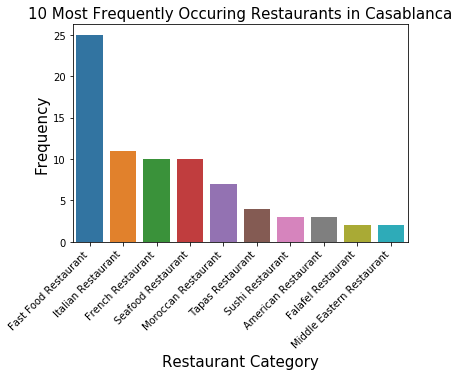

<Figure size 1296x504 with 0 Axes>

In [121]:
import seaborn as sns
from matplotlib import pyplot as plt

casa_restaurant_top10=(casa_restaurants['Category'].value_counts())[0:10].to_frame()
casa_restaurant_top10.rename(columns={"Category": "frequency"}, inplace=True)
casa_restaurant_top10=casa_restaurant_top10.reset_index()
casa_restaurant_top10.rename(columns={"index": "category"}, inplace=True)

s=sns.barplot(x="category", y="frequency", data=casa_restaurant_top10)
s.set_xticklabels(s.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.title('10 Most Frequently Occuring Restaurants in Casablanca', fontsize=15)
plt.xlabel("Restaurant Category", fontsize=15)
plt.ylabel ("Frequency", fontsize=15)
plt.savefig("Most_Freq_Venues1.png", dpi=300)
fig = plt.figure(figsize=(18,7))
plt.show()





## 2. Analyze Each Borough

In [122]:
# one hot encoding
casa_venues_ana = pd.get_dummies(casa_restaurants[['Category']], prefix="", prefix_sep="")
# add neighborhood column back to dataframe
casa_venues_ana['Borough'] = casa_restaurants['Borough'] 

# move neighborhood column to the first column
fixed_columns = [casa_venues_ana.columns[-1]] + list(casa_venues_ana.columns[:-2])
casa_venues_ana = casa_venues_ana[fixed_columns]

casa_venues_ana.head()


,Borough,American Restaurant,Asian Restaurant,Brazilian Restaurant,Chinese Restaurant,Doner Restaurant,Falafel Restaurant,Fast Food Restaurant,French Restaurant,Italian Restaurant,Japanese Restaurant,Kebab Restaurant,Mediterranean Restaurant,Middle Eastern Restaurant,Moroccan Restaurant,Seafood Restaurant,Spanish Restaurant,Sushi Restaurant,Tapas Restaurant
1,Casablanca,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,Casablanca,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,Casablanca,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
8,Casablanca,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
9,Casablanca,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [123]:
casa_venues_gr = casa_venues_ana.groupby('Borough').mean().reset_index()
print(casa_venues_gr.shape)
casa_venues_gr

(15, 19)


,Borough,American Restaurant,Asian Restaurant,Brazilian Restaurant,Chinese Restaurant,Doner Restaurant,Falafel Restaurant,Fast Food Restaurant,French Restaurant,Italian Restaurant,Japanese Restaurant,Kebab Restaurant,Mediterranean Restaurant,Middle Eastern Restaurant,Moroccan Restaurant,Seafood Restaurant,Spanish Restaurant,Sushi Restaurant,Tapas Restaurant
0,Ain harrouda,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
1,Anfa,0.000000,0.000000,0.000000,0.000000,0.090909,0.000000,0.272727,0.000000,0.272727,0.000000,0.000000,0.090909,0.090909,0.090909,0.000000,0.000000,0.000000,0.090909
2,Assoukhour assawda,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,Aîn-chock,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.250000,0.000000
4,Aîn-sebaâ,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,Casablanca,0.037037,0.000000,0.000000,0.037037,0.037037,0.000000,0.222222,0.185185,0.037037,0.000000,0.037037,0.037037,0.000000,0.111111,0.185185,0.037037,0.000000,0.037037
6,Dar bouazza,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000,0.000000,0.666667,0.000000,0.000000,0.000000
7,El-fida casablanca,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,0.600000,0.000000,0.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,Hay mohammadi,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,Maarif casablanca,0.166667,0.000000,0.000000,0.000000,0.000000,0.000000,0.166667,0.000000,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000


### Create a new dataframe and display the top 10 venues for each Borough.

In [124]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]


In [170]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Borough']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Restaurant'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Restaurant'.format(ind+1))

# create a new dataframe
casa_venues_sorted = pd.DataFrame(columns=columns)
casa_venues_sorted['Borough'] = casa_venues_gr['Borough']

for ind in np.arange(casa_venues_gr.shape[0]):
    casa_venues_sorted.iloc[ind, 1:] = return_most_common_venues(casa_venues_gr.iloc[ind, :], num_top_venues)

casa_venues_sorted

,Borough,1st Most Common Restaurant,2nd Most Common Restaurant,3rd Most Common Restaurant,4th Most Common Restaurant,5th Most Common Restaurant,6th Most Common Restaurant,7th Most Common Restaurant,8th Most Common Restaurant,9th Most Common Restaurant,10th Most Common Restaurant
0,Ain harrouda,Moroccan Restaurant,Tapas Restaurant,French Restaurant,Asian Restaurant,Brazilian Restaurant,Chinese Restaurant,Doner Restaurant,Falafel Restaurant,Fast Food Restaurant,Italian Restaurant
1,Anfa,Italian Restaurant,Fast Food Restaurant,Middle Eastern Restaurant,Doner Restaurant,Mediterranean Restaurant,Tapas Restaurant,Moroccan Restaurant,Kebab Restaurant,Japanese Restaurant,Sushi Restaurant
2,Assoukhour assawda,Fast Food Restaurant,Tapas Restaurant,Sushi Restaurant,Asian Restaurant,Brazilian Restaurant,Chinese Restaurant,Doner Restaurant,Falafel Restaurant,French Restaurant,Italian Restaurant
3,Aîn-chock,Fast Food Restaurant,Sushi Restaurant,Tapas Restaurant,Asian Restaurant,Brazilian Restaurant,Chinese Restaurant,Doner Restaurant,Falafel Restaurant,French Restaurant,Italian Restaurant
4,Aîn-sebaâ,Italian Restaurant,Sushi Restaurant,Asian Restaurant,Brazilian Restaurant,Chinese Restaurant,Doner Restaurant,Falafel Restaurant,Fast Food Restaurant,French Restaurant,Tapas Restaurant
5,Casablanca,Fast Food Restaurant,French Restaurant,Seafood Restaurant,Moroccan Restaurant,Tapas Restaurant,Chinese Restaurant,Doner Restaurant,Italian Restaurant,Kebab Restaurant,Mediterranean Restaurant
6,Dar bouazza,Seafood Restaurant,Japanese Restaurant,Tapas Restaurant,French Restaurant,Asian Restaurant,Brazilian Restaurant,Chinese Restaurant,Doner Restaurant,Falafel Restaurant,Fast Food Restaurant
7,El-fida casablanca,Fast Food Restaurant,Italian Restaurant,Falafel Restaurant,Sushi Restaurant,Asian Restaurant,Brazilian Restaurant,Chinese Restaurant,Doner Restaurant,French Restaurant,Tapas Restaurant
8,Hay mohammadi,Fast Food Restaurant,Tapas Restaurant,Sushi Restaurant,Asian Restaurant,Brazilian Restaurant,Chinese Restaurant,Doner Restaurant,Falafel Restaurant,French Restaurant,Italian Restaurant
9,Maarif casablanca,Italian Restaurant,Seafood Restaurant,Fast Food Restaurant,American Restaurant,Moroccan Restaurant,Middle Eastern Restaurant,Mediterranean Restaurant,Kebab Restaurant,Japanese Restaurant,Sushi Restaurant


## 3. Clustering the Boroughs bt Restaurants

In [171]:
# set number of clusters
kclusters = 4

casa_clustering = casa_venues_gr.drop('Borough', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(casa_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:50] 



array([1, 3, 2, 2, 0, 3, 3, 2, 2, 3, 1, 1, 2, 2, 3], dtype=int32)

In [172]:
# add clustering labels
casa_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

casa_merged = df

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
casa_merged = casa_merged.join(casa_venues_sorted.set_index('Borough'), on='Borough')

casa_merged # check the last columns!

,Borough,Latitude,Longitude,Cluster Labels,1st Most Common Restaurant,2nd Most Common Restaurant,3rd Most Common Restaurant,4th Most Common Restaurant,5th Most Common Restaurant,6th Most Common Restaurant,7th Most Common Restaurant,8th Most Common Restaurant,9th Most Common Restaurant,10th Most Common Restaurant
2,Casablanca,33.595063,-7.618777,3.0,Fast Food Restaurant,French Restaurant,Seafood Restaurant,Moroccan Restaurant,Tapas Restaurant,Chinese Restaurant,Doner Restaurant,Italian Restaurant,Kebab Restaurant,Mediterranean Restaurant
3,Aîn-chock,33.536215,-7.615698,2.0,Fast Food Restaurant,Sushi Restaurant,Tapas Restaurant,Asian Restaurant,Brazilian Restaurant,Chinese Restaurant,Doner Restaurant,Falafel Restaurant,French Restaurant,Italian Restaurant
4,Aîn-sebaâ,33.608591,-7.524144,0.0,Italian Restaurant,Sushi Restaurant,Asian Restaurant,Brazilian Restaurant,Chinese Restaurant,Doner Restaurant,Falafel Restaurant,Fast Food Restaurant,French Restaurant,Tapas Restaurant
5,Anfa,33.592632,-7.672177,3.0,Italian Restaurant,Fast Food Restaurant,Middle Eastern Restaurant,Doner Restaurant,Mediterranean Restaurant,Tapas Restaurant,Moroccan Restaurant,Kebab Restaurant,Japanese Restaurant,Sushi Restaurant
6,El-fida casablanca,33.566522,-7.607288,2.0,Fast Food Restaurant,Italian Restaurant,Falafel Restaurant,Sushi Restaurant,Asian Restaurant,Brazilian Restaurant,Chinese Restaurant,Doner Restaurant,French Restaurant,Tapas Restaurant
7,Assoukhour assawda,33.586519,-7.588056,2.0,Fast Food Restaurant,Tapas Restaurant,Sushi Restaurant,Asian Restaurant,Brazilian Restaurant,Chinese Restaurant,Doner Restaurant,Falafel Restaurant,French Restaurant,Italian Restaurant
8,Ben m'sick,33.554261,-7.581366,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,Maarif casablanca,33.576130,-7.636660,3.0,Italian Restaurant,Seafood Restaurant,Fast Food Restaurant,American Restaurant,Moroccan Restaurant,Middle Eastern Restaurant,Mediterranean Restaurant,Kebab Restaurant,Japanese Restaurant,Sushi Restaurant
10,Hay-hassani,33.567046,-7.678489,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,Hay mohammadi,33.584144,-7.556956,2.0,Fast Food Restaurant,Tapas Restaurant,Sushi Restaurant,Asian Restaurant,Brazilian Restaurant,Chinese Restaurant,Doner Restaurant,Falafel Restaurant,French Restaurant,Italian Restaurant


In [176]:
'''casa_merged.rename(columns={"Cluster Labels": "Cluster_labels"}, inplace=True)
casa_merged=casa_merged.dropna()
casa_merged'''
casa_merged["Cluster_labels"] = casa_merged["Cluster_labels"].astype(int)
casa_merged

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,Borough,Latitude,Longitude,Cluster_labels,1st Most Common Restaurant,2nd Most Common Restaurant,3rd Most Common Restaurant,4th Most Common Restaurant,5th Most Common Restaurant,6th Most Common Restaurant,7th Most Common Restaurant,8th Most Common Restaurant,9th Most Common Restaurant,10th Most Common Restaurant
2,Casablanca,33.595063,-7.618777,3,Fast Food Restaurant,French Restaurant,Seafood Restaurant,Moroccan Restaurant,Tapas Restaurant,Chinese Restaurant,Doner Restaurant,Italian Restaurant,Kebab Restaurant,Mediterranean Restaurant
3,Aîn-chock,33.536215,-7.615698,2,Fast Food Restaurant,Sushi Restaurant,Tapas Restaurant,Asian Restaurant,Brazilian Restaurant,Chinese Restaurant,Doner Restaurant,Falafel Restaurant,French Restaurant,Italian Restaurant
4,Aîn-sebaâ,33.608591,-7.524144,0,Italian Restaurant,Sushi Restaurant,Asian Restaurant,Brazilian Restaurant,Chinese Restaurant,Doner Restaurant,Falafel Restaurant,Fast Food Restaurant,French Restaurant,Tapas Restaurant
5,Anfa,33.592632,-7.672177,3,Italian Restaurant,Fast Food Restaurant,Middle Eastern Restaurant,Doner Restaurant,Mediterranean Restaurant,Tapas Restaurant,Moroccan Restaurant,Kebab Restaurant,Japanese Restaurant,Sushi Restaurant
6,El-fida casablanca,33.566522,-7.607288,2,Fast Food Restaurant,Italian Restaurant,Falafel Restaurant,Sushi Restaurant,Asian Restaurant,Brazilian Restaurant,Chinese Restaurant,Doner Restaurant,French Restaurant,Tapas Restaurant
7,Assoukhour assawda,33.586519,-7.588056,2,Fast Food Restaurant,Tapas Restaurant,Sushi Restaurant,Asian Restaurant,Brazilian Restaurant,Chinese Restaurant,Doner Restaurant,Falafel Restaurant,French Restaurant,Italian Restaurant
9,Maarif casablanca,33.576130,-7.636660,3,Italian Restaurant,Seafood Restaurant,Fast Food Restaurant,American Restaurant,Moroccan Restaurant,Middle Eastern Restaurant,Mediterranean Restaurant,Kebab Restaurant,Japanese Restaurant,Sushi Restaurant
11,Hay mohammadi,33.584144,-7.556956,2,Fast Food Restaurant,Tapas Restaurant,Sushi Restaurant,Asian Restaurant,Brazilian Restaurant,Chinese Restaurant,Doner Restaurant,Falafel Restaurant,French Restaurant,Italian Restaurant
12,Mers-sultan,33.575768,-7.599929,1,Moroccan Restaurant,Fast Food Restaurant,Tapas Restaurant,French Restaurant,Asian Restaurant,Brazilian Restaurant,Chinese Restaurant,Doner Restaurant,Falafel Restaurant,Italian Restaurant
14,Sbata,33.880766,-5.566873,2,Fast Food Restaurant,Tapas Restaurant,Sushi Restaurant,Asian Restaurant,Brazilian Restaurant,Chinese Restaurant,Doner Restaurant,Falafel Restaurant,French Restaurant,Italian Restaurant


### Create a map of Toronto with venues Clustered to 5 Clusters superimposed on top.

In [182]:
import matplotlib.cm as cm
import matplotlib.colors as colors

# create map
map_clusters = folium.Map(location=[33.595063,-7.618777], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(casa_merged['Latitude'], casa_merged['Longitude'], casa_merged['Borough'], casa_merged['Cluster_labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters